<a href="https://colab.research.google.com/github/HMRLKE/FanSpeed-Fuzzy-demo/blob/master/wine_class_georges_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

         Programming a neural network for predicting wine quality
                             George McClelland

Task:

The output will be a functioning python code (network training and testing with printed outputs) and a short report (one page A4) on what you did, how, and what the results were. In addition to network accuracy (training and testing), calculate also the confusion matrix (i.e. misclassifications)


In [20]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.compat.v2.feature_column as fc


The first issue was prepossessing. The data were separated by semicolons rather than commas, so were being stored in the same column. This was relatively simple to solve using find and replace. Later on, the classifier was having a problem reading the whitespace in the column names, and this was solved in a similar fashion (but with a lot more pain in identifying the issue).

In [31]:
from google.colab import files 
import io

wine = files.upload() #get data
wine = pd.read_csv(io.BytesIO(wine['wine_orig.csv']),sep=';') #convert to pd df

#wine = pd.read_csv(wine.csv)  -- if running locally


Saving wine_orig.csv to wine_orig (3).csv


Then the data needed to be split into training and testing (I used the standard 8:2 ratio), and the target labels removed.

In [163]:
#separate training and testing data
train =  wine.sample(frac=0.9, random_state=1) #percent and seed
test = wine.drop(train.index) #makes test batch from complement of train - i.e. 0.2



test.shape
train.shape
#print(train.columns.tolist())


y_train = train.pop("quality") #removes labels
y_test = test.pop("quality")
#print(y_train.max())


In [164]:
import pandas as pd
from sklearn import preprocessing

 #returns a numpy array



#Normalize the features
def normalize(df):
  X = df.values
  normalized = StandardScaler().fit_transform(X)
  #min_max_scaler = preprocessing.MinMaxScaler()
  out = pd.DataFrame(normalized)
  out.columns = df.columns.tolist()
  return out

n_train = normalize(train)
n_test = normalize(test)
#print(n_train.columns)

First of all I tried using a linear regression model, but the results were very bad. Initial accuracy was 45%, and increasing the number of epochs had only a minimal impact on accuracy (51%). Uncomment code below if you want to run it but it's not that important. Once run start again from cell 1 before proceding with the rest of the code.

In [ ]:
# def make_input_fn(data_df, label_df, num_epochs=50, shuffle=True, batch_size=42): 
#   def input_function():  # inner function, this will be returned
#     ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its label
#     if shuffle:
#       ds = ds.shuffle(1000)  # randomize order of data
#     ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches and repeat process for number of epochs
#     return ds  # return a batch of the dataset
#   return input_function  # return a function object for use


# columns = ["fixed acidity",	"volatile acidity",	"citric acid",	"residual sugar",	"chlorides",	"free sulfur dioxide",	"total sulfur dioxide",	"density",	"pH",	"sulphates",	"alcohol"]
# columns = [ col.replace(' ', '_') for col in columns]
# wine.columns = [ col.replace(' ', '_') for col in wine.columns] #it kept throwing 'ValueError: 'citric acid' is not a valid scope name', took me a very long time to work out it was because of the " " spaces
# feature_columns=[]
# for feature_name in columns:
#   feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))


# train_input = make_input_fn(train, y_train)
# test_input = make_input_fn(test, y_test, num_epochs=1,shuffle=False)

# lin_est = tf.estimator.LinearClassifier(feature_columns=feature_columns,n_classes=10) #creates the model with feature columns, n_classes argument resolved an error in next step

# lin_est.train(train_input)

# result = lin_est.evaluate(test_input)  # tests on tetsing data
# print(result['accuracy'])

I thought that the accuracy may be low because the data may not be linearly separable, so I tweaked the code to instead be a deep neural classifier. Like the previous model, there were originally 7 target classes (the ratings 3-9), which could be expanded to 10 (1-10) if needed for new data. I was surprised, however, when the results of this model were similarly poor. Again, tweaking the parameters of the model made very little difference to the accuracy, but I then realised that the problem may be the number of target classes. Reducing the scores to 1-3 (respectively “good”, “medium”, “poor”) made a significant impact on the accuracy of the model, as it could more easily distinguish between the smaller number of classes and had less chance of misclassification. The results for the original linear model were now also much better with only 3 output variables. Although this is perhaps not as specific as the exact rating, an alternative may be to treat the labels as ordinal rather than categorical values, so a misclassification of a score of 8 as being 7 would be “more accurate” than as 3. However this seemed beyond the scope of the project.

In [165]:
#reduces number of classes to 3 - make sure to only run once!
y_train = y_train.replace([10,9,8,7,6,5,4,3,2,1],[2,2,2,2,1,1,0,0,0,0])
y_test = y_test.replace([10,9,8,7,6,5,4,3,2,1],[2,2,2,2,1,1,0,0,0,0])

#print(y_test.head())
print(y_train.head())
classes = {2:"good",1:"average",0:"poor"}

75      1
1283    1
408     1
1281    1
1118    1
Name: quality, dtype: int64


In [166]:
#columns = ["fixed acidity",	"volatile acidity",	"citric acid",	"residual sugar",	"chlorides",	"free sulfur dioxide",	"total sulfur dioxide",	"density",	"pH",	"sulphates",	"alcohol"]
columns = train.columns.tolist()

columns = [ col.replace(' ', '_') for col in columns]
wine.columns = [ col.replace(' ', '_') for col in wine.columns] #it kept throwing 'ValueError: 'citric acid' is not a valid scope name', took me a very long time to work out it was because of the " " spaces
feature_columns=[]
for feature_name in columns:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))
print(feature_columns)

[NumericColumn(key='fixed_acidity', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='volatile_acidity', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='citric_acid', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='residual_sugar', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='chlorides', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='free_sulfur_dioxide', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='total_sulfur_dioxide', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='density', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='pH', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='sulphates', shape=(1,), default_

In [168]:
#i lifted this almost directly from the web cus it was too complicated making my own input function from scratch

def input_fn(features, labels, training=True, batch_size=32):
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

    # Shuffle and repeat if you are in training mode.
    if training:
        dataset = dataset.shuffle(1000).repeat()
    
    return dataset.batch(batch_size)

In [169]:
#build dnn model
classifier = tf.estimator.DNNClassifier(
    feature_columns=feature_columns,
    # 2 hidden layers with 30 nodes in 1st and 10 in 2nd, adding more layers and nodes made very little difference to accuracy
    hidden_units=[30,10],
    # 3 classes: 1-3, changed to 4 to avoid error at training stage "[Labels must be <= n_classes - 1]"
    n_classes=3)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpjams4lw2', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [172]:
classifier.train(input_fn = lambda: input_fn(n_train,y_train,training=True), steps=50000)


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpjams4lw2/model.ckpt-15000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 15000...
INFO:tensorflow:Saving checkpoints for 15000 into /tmp/tmpjams4lw2/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 15000...
INFO:tensorflow:loss = 0.42520893, step = 15000
INFO:tensorflow:global_step/sec: 469.413
INFO:tensorflow:loss = 0.4262872, step = 15100 (0.215 sec)
INFO:tensorflow:global_step/sec: 705.303
INFO:tensorflow:loss = 0.67548805, step = 15200 (0.144 sec)
INFO:tensorflow:global_step/sec: 646.709
INFO:tensorflow:loss = 0.6917648, step = 15300 (0.152 sec)
INFO:tensorflow:global_step/sec: 762.509
INFO:tensorflow:loss = 0.7447685, step = 15400 (0.135 sec)
IN

In [173]:
result = classifier.evaluate(input_fn=lambda: input_fn(n_test, y_test, training=False)) 

print(result)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-01-04T13:31:45Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpjams4lw2/model.ckpt-65000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.25511s
INFO:tensorflow:Finished evaluation at 2021-01-04-13:31:45
INFO:tensorflow:Saving dict for global step 65000: accuracy = 0.86875, average_loss = 0.3691084, global_step = 65000, loss = 0.3691084
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 65000: /tmp/tmpjams4lw2/model.ckpt-65000
{'accuracy': 0.86875, 'average_loss': 0.3691084, 'loss': 0.3691084, 'global_step': 65000}


As can be seen from the distribution of the data (predominantly around the 5-7 range - i.e. “medium”) the model’s accuracy rate is predominantly a result of it classifying almost everything as “medium”, which is due to the screwing of the ground truth data. Depending on the purpose of the model, this could cause issues. If the priority was to avoid poor quality wine at all costs, then the misclassification of “poor” wine as “medium” would be a big mistake. If needed, this could be corrected either by having more (or different) training data, or by placing greater weight on certain classes over others.

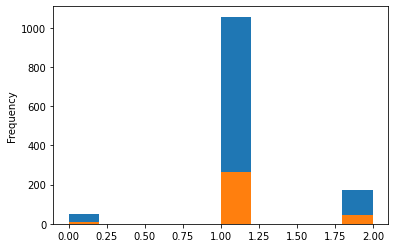

In [137]:
y_train.plot.hist() #blue
y_test.plot.hist() #orange

This is made even more clear by the confusion matrix, where none of the "good" or "poor" wines are categorised correctly, and the vast majority of misclassifications are as "medium".

In [178]:
def input_fn_pred(features, batch_size=32):
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices(dict(features))
    return dataset.batch(batch_size)

preds = []

for key, single_prediction in enumerate(classifier.predict(input_fn=lambda :input_fn_pred(n_test))):
  preds.append(single_prediction['class_ids'][0])


confusion = tf.math.confusion_matrix(labels=y_test, predictions=preds)
confusion
#columns are predictions, rows are real values

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpjams4lw2/model.ckpt-65000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[  0,   5,   0],
       [  0, 127,   2],
       [  0,  14,  12]], dtype=int32)>